In [1]:
# 파일이름 : LAB_data_generator.ipynb|
# 코드설명 : 고무 배합비와 연구소 검사 데이터에 대한 전처리 및 모델 학습 데이터 세트 생성
# 입/출력 : 배합정보, LAB 검사결과, 원재료코드분류 / LAB 데이터 세트(7개)"
# 최종수정 : 2023년 11월 23일
# 제 작 자 : 홍민성 (mshong@micube.co.kr), 맹영준 (myj6223@micube.co.kr)
# Copyright : MICUBE Solution, Inc.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist]
#print(font_list)

# 한글 폰트 설정
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False # 유니코드 마이너스 사용 설정 (깨지는 문제 방지)

sns.set(font="NanumGothic", # 일반적으로 설치되어 있는 폰트로 변경
        rc={"axes.unicode_minus": False, "figure.figsize": (20, 8)}, # figure size와 unicode_min
        style='darkgrid',
        font_scale=0.8) # 폰트 크기 설정 추가

import pandas as pd
import numpy as np
import matplotlib
import warnings
%matplotlib inline
warnings.filterwarnings(action='ignore')
pd.set_option("display.max_columns", 500)
pd.set_option('display.max_rows', 50)
import os
import koreanize_matplotlib
import pingouin as pg
from tqdm.auto import tqdm

## 1. 데이터 로드 및 통합

### 1) 데이터 로드

In [2]:
lab_recipe_df=pd.read_csv('./dataset/sfitapp_recipe_lab.csv', encoding='cp949')           # 배합비 데이터
lab_insp_df=pd.read_csv('./dataset/sfitapp_insp_lab.csv', encoding='cp949')         # 검사 데이터
lar_cd_df=pd.read_excel('./dataset/jrcode_230907_fin.xlsx')             # 원재료 코드 및 분류표

mes_full_df=pd.read_pickle('./dataset/24-sfites_real_mix_data_full.pkl')
mes_mny_temp=pd.read_csv('./dataset/mny_temp.csv', encoding='cp949')
mes_full_df = mes_full_df[[col for col in mes_full_df.columns if col!='MNY_TEMP']].merge(mes_mny_temp, how='inner', on='LOTNO')

In [7]:
len(mes_full_df), len(mes_full_df[mes_full_df['MNY_TIME'].isna()]), len(mes_full_df[mes_full_df['MNY_TEMP'].isna()])

(841287, 667725, 186749)

In [5]:
### 이슈5 변경사항 ###
lab_insp_df['lab_cd'] = lab_insp_df['lab_cd'].str.replace('-','')
lab_insp_df['ID'] = lab_insp_df['lab_cd'] + '_' + lab_insp_df['test_no']
mes_full_df['ID'] = mes_full_df['LOTNO']

### 2) LAB, MES 데이터 상 공통 변수 선정 및 컬럼명 통일

In [6]:
trg_regression_cols = ['pps_hs','pps_sg','pps_ts','pps_eb','pps_temp','pps_mnt','MNY','RHeO']
trg_lab_cols = [col for col in lab_insp_df.columns if 
                (len([inCol for inCol in trg_regression_cols if inCol.lower() in col]) != 0) 
                and ("std" not in col) and ("mny_mls" not in col) and ("mny_mv" not in col) and ("mny_t15" not in col) and ("mny_t30" not in col)
                and ("rheo_t10" not in col) and ("rheo_t50" not in col) and ("mny_t30" not in col)]
trg_lab_cols = trg_lab_cols + ['ID']
trg_lab_cols.sort()
print(len(trg_lab_cols), trg_lab_cols)
lab_df = lab_insp_df[trg_lab_cols]
lab_df.rename(columns={'insp_mny_148_val':'MNY_TIME', 'insp_mny_min_val':'MNY_MIN', 'insp_mny_t35_val':'MNY_T35', 'insp_mny_t5_val':'MNY_T5', 'insp_mny_temp_val':'MNY_TEMP', 
'insp_pps_eb_val':'EB', 'insp_pps_hs_val':'HS', 'insp_pps_sg_val':'SG', 'insp_pps_ts_val':'TS', 'insp_rheo_max_val':'REHO_MAX', 'insp_pps_temp_val':'PPS_TEMP', 'insp_pps_mnt_val':'PPS_TIME', 
'insp_rheo_min_val':'REHO_MIN', 'insp_rheo_mnt_val':'REHO_TIME', 'insp_rheo_t90_val':'REHO_TC90', 'insp_rheo_temp_val':'REHO_TEMP', 'insp_rheo_ts2_val':'REHO_TS2'}, errors="raise", inplace=True)

# 공통 검사조건(TIME, TEMP)을 기본물성별로 복제
pps_ls = ['HS','SG','TS','EB']
for pps in pps_ls:    
    lab_df[pps+'_TIME'] = lab_df['PPS_TIME']
    lab_df[pps+'_TEMP'] = lab_df['PPS_TEMP']
lab_df.drop(columns=['PPS_TIME','PPS_TEMP'],inplace=True)
print(len(lab_df.columns), lab_df.columns)

18 ['ID', 'insp_mny_148_val', 'insp_mny_min_val', 'insp_mny_t35_val', 'insp_mny_t5_val', 'insp_mny_temp_val', 'insp_pps_eb_val', 'insp_pps_hs_val', 'insp_pps_mnt_val', 'insp_pps_sg_val', 'insp_pps_temp_val', 'insp_pps_ts_val', 'insp_rheo_max_val', 'insp_rheo_min_val', 'insp_rheo_mnt_val', 'insp_rheo_t90_val', 'insp_rheo_temp_val', 'insp_rheo_ts2_val']
24 Index(['ID', 'MNY_TIME', 'MNY_MIN', 'MNY_T35', 'MNY_T5', 'MNY_TEMP', 'EB',
       'HS', 'SG', 'TS', 'REHO_MAX', 'REHO_MIN', 'REHO_TIME', 'REHO_TC90',
       'REHO_TEMP', 'REHO_TS2', 'HS_TIME', 'HS_TEMP', 'SG_TIME', 'SG_TEMP',
       'TS_TIME', 'TS_TEMP', 'EB_TIME', 'EB_TEMP'],
      dtype='object')


In [7]:
trg_regression_cols = ['HS','SG','TS','EB','MNY','REHO']
trg_mes_cols = [col for col in mes_full_df.columns if (len([inCol for inCol in trg_regression_cols if inCol in col]) != 0) and ("RESULT" not in col)]
trg_mes_cols = trg_mes_cols + ['ID']
trg_mes_cols.sort()
print(len(trg_mes_cols), trg_mes_cols)
mes_df = mes_full_df[trg_mes_cols]

24 ['EB', 'EB_TEMP', 'EB_TIME', 'HS', 'HS_TEMP', 'HS_TIME', 'ID', 'MNY_MIN', 'MNY_T35', 'MNY_T5', 'MNY_TEMP', 'MNY_TIME', 'REHO_MAX', 'REHO_MIN', 'REHO_TC90', 'REHO_TEMP', 'REHO_TIME', 'REHO_TS2', 'SG', 'SG_TEMP', 'SG_TIME', 'TS', 'TS_TEMP', 'TS_TIME']


### 3) 결합 데이터 이상치 제거 및 LAB, MES 데이터 통합

In [8]:
lab_df = lab_df[mes_df.columns]

In [9]:
tmp_lab_df = lab_df.copy()

import re

# 연산자 적용 함수
def apply_operator(expression):
    if isinstance(expression, (int, float)):
        return expression
    if re.match("^[0-9+\-*/]+$", expression):
        try:
            return eval(expression)
        except ZeroDivisionError:
            return "Division by zero"
        except Exception as e:
            return str(e)
    else:
        return expression

tmp_lab_df = tmp_lab_df.applymap(apply_operator)

def convert_time(time_str):
    if isinstance(time_str, str):
        try:
            return pd.to_datetime(time_str, format='%H:%M:%S').time()
        except ValueError:
            try:
                return pd.to_datetime(time_str, format='%M:%S').time()
            except ValueError:
                return time_str
    return time_str

tmp_lab_df['MNY_T5'] = tmp_lab_df['MNY_T5'].astype(str).replace('::', ':', regex=False)
tmp_lab_df['MNY_T5'] = tmp_lab_df['MNY_T5'].astype(str).replace(':.', ':', regex=False)
tmp_lab_df['MNY_T5'] = tmp_lab_df['MNY_T5'].astype(str).replace(';', ':', regex=False)
tmp_lab_df['MNY_T5'] = tmp_lab_df['MNY_T5'].astype(str).replace('\t', '', regex=False)
tmp_lab_df['MNY_T5'] = tmp_lab_df['MNY_T5'].astype(str).replace(':.', ':', regex=False)

tmp_lab_df['MNY_T5'] = tmp_lab_df['MNY_T5'].apply(convert_time)


tmp_lab_df['MNY_T35'] = tmp_lab_df['MNY_T35'].astype(str).replace('\'', '', regex=False)
tmp_lab_df['MNY_T35'] = tmp_lab_df['MNY_T35'].astype(str).replace('"', '', regex=False)

import re

def remove_trailing_zeros(value):
    if isinstance(value, str):
        if re.match(r'^\d+:\d+:00$', value):
            return value[:-3]
    return value

tmp_lab_df['MNY_T35'] = tmp_lab_df['MNY_T35'].apply(remove_trailing_zeros)
tmp_lab_df['MNY_T35'] = tmp_lab_df['MNY_T35'].apply(convert_time)

In [10]:
import datetime
def str_time_to_seconds(time_str):
    # 'H:M:S' 형식으로 시도
    time_val = pd.to_datetime(time_str, format='%H:%M:%S', errors='coerce')
    if pd.isna(time_val):
        # 'H:M:S' 형식이 실패하면 'M:S' 형식으로 시도
        time_val = pd.to_datetime(time_str, format='%M:%S', errors='coerce')
        if pd.isna(time_val):
            # 모든 형식이 실패하면 원래 문자열 반환
            return time_str
        else:
            delta = datetime.timedelta(minutes=time_val.minute, seconds=time_val.second)
    else:
        delta = datetime.timedelta(hours=time_val.hour, minutes=time_val.minute, seconds=time_val.second)
    return int(delta.total_seconds())

In [11]:
tmp_lab_df = tmp_lab_df.applymap(str_time_to_seconds)

In [12]:
# # 원하는 컬럼 선택
# columns = ['MNY_T35', 'MNY_T5', 'MNY_TEMP', 'MNY_TIME', 'REHO_MAX', 'REHO_MIN', 'REHO_TC90', 'REHO_TEMP', 'REHO_TIME', 'REHO_TS2']

# # NaN 값을 포함하지 않는 행만 필터링
# filtered_df = tmp_lab_df[columns].dropna()
# filtered_df

In [13]:
def find_non_convertible_values(df):
    non_convertible_values = {}
    for col in df.select_dtypes(include=['object']).columns:  # object 타입 컬럼만 순회
        # 숫자로 변환을 시도하고, 변환되지 않는 값들은 NaN으로 대체
        temp_series = pd.to_numeric(df[col], errors='coerce')        
        # NaN이 있는 원래 데이터의 값들을 추출
        non_convertible = df[col][temp_series.isna() & df[col].notna()]        
        # 중복을 제거하고 NumPy 배열로 저장
        non_convertible_values[col] = np.array(non_convertible.drop_duplicates(), dtype=object)
        print('이상 데이터 비율 : '+str(np.round(len(non_convertible)/len(df)*100, 2))+'%\t', '개수/종류 : '+str(len(non_convertible))+'/'+str(len(non_convertible_values[col]))+'개\t', col)
    
    return non_convertible_values

# 함수 적용
find_non_convertible_values(tmp_lab_df)

이상 데이터 비율 : 0.22%	 개수/종류 : 16/9개	 EB
이상 데이터 비율 : 1.08%	 개수/종류 : 80/14개	 EB_TEMP
이상 데이터 비율 : 1.16%	 개수/종류 : 86/20개	 EB_TIME
이상 데이터 비율 : 1.86%	 개수/종류 : 138/52개	 HS
이상 데이터 비율 : 1.08%	 개수/종류 : 80/14개	 HS_TEMP
이상 데이터 비율 : 1.16%	 개수/종류 : 86/20개	 HS_TIME
이상 데이터 비율 : 100.0%	 개수/종류 : 7438/7438개	 ID
이상 데이터 비율 : 0.65%	 개수/종류 : 48/14개	 MNY_MIN
이상 데이터 비율 : 46.81%	 개수/종류 : 3482/137개	 MNY_T35
이상 데이터 비율 : 39.37%	 개수/종류 : 2928/24개	 MNY_T5
이상 데이터 비율 : 0.04%	 개수/종류 : 3/3개	 MNY_TEMP
이상 데이터 비율 : 0.01%	 개수/종류 : 1/1개	 MNY_TIME
이상 데이터 비율 : 0.11%	 개수/종류 : 8/7개	 REHO_MAX
이상 데이터 비율 : 0.12%	 개수/종류 : 9/8개	 REHO_MIN
이상 데이터 비율 : 0.04%	 개수/종류 : 3/2개	 REHO_TC90
이상 데이터 비율 : 0.27%	 개수/종류 : 20/10개	 REHO_TEMP
이상 데이터 비율 : 0.03%	 개수/종류 : 2/2개	 REHO_TIME
이상 데이터 비율 : 0.16%	 개수/종류 : 12/6개	 REHO_TS2
이상 데이터 비율 : 0.46%	 개수/종류 : 34/27개	 SG
이상 데이터 비율 : 1.08%	 개수/종류 : 80/14개	 SG_TEMP
이상 데이터 비율 : 1.16%	 개수/종류 : 86/20개	 SG_TIME
이상 데이터 비율 : 0.26%	 개수/종류 : 19/11개	 TS
이상 데이터 비율 : 1.08%	 개수/종류 : 80/14개	 TS_TEMP
이상 데이터 비율 : 1.16%	 개수/종류 : 

{'EB': array(['x', '582 / 772', '774 (643)', 'T1 540', 'NG(인장성형안됨)',
        'invalid syntax (<string>, line 1)', '378 (양품DATA)', '미실시',
        '1,076'], dtype=object),
 'EB_TEMP': array(['170℃*10分', '180(180)', '170 (180)', '170 (150)(150)', '170 (150)',
        '170 (x)', '180 (2차180℃)', '190 (발포비중)', '170(발포비중)',
        '180 (후가류 180)', '180 (150)', '오븐 240', '160 / 160', '160 / '],
       dtype=object),
 'EB_TIME': array(['180℃*2HR 후가류',
        'leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<string>, line 1)',
        '6(3hrs)', '15 (4hrs)', '10 (1hrs)(2hrs)', '10 (1hrs)',
        '10 (180*40분 후가류)', '10 (x)', '200초', '10 (2hrs)', '180초',
        '10 (4HR)', '5(2차 4hrs)', '15 (4 HRS)', '10(180*40분 후가류)',
        '8 (후가류 40) -C/SET함께', '8 (4hrs)', '10월 06일', '10월 15일', 'MDR-2'],
       dtype=object),
 'HS': array(['72~73/80', '미실시', '배합 미실시', 'x', '46>47', '41->42(경시)', '52->53',
        '39->40', '38->40', '45->47', '45>46', '4

In [14]:
def replace_non_numeric_with_nan(df):
    for col in df.columns:
        # 컬럼의 데이터 타입이 object인 경우에만 처리
        if df[col].dtype == 'object' and col != 'ID':
            # 숫자로 변환 가능한지 확인하고, 불가능한 경우 NaN으로 설정
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df
replace_non_numeric_with_nan(tmp_lab_df)

,EB,EB_TEMP,EB_TIME,HS,HS_TEMP,HS_TIME,ID,MNY_MIN,MNY_T35,MNY_T5,MNY_TEMP,MNY_TIME,REHO_MAX,REHO_MIN,REHO_TC90,REHO_TEMP,REHO_TIME,REHO_TS2,SG,SG_TEMP,SG_TIME,TS,TS_TEMP,TS_TIME
0,NaN,160.0,10.0,NaN,160.0,10.0,0000QA001_T001,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0
1,NaN,170.0,10.0,NaN,170.0,10.0,0000QY001_K001,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0
2,NaN,170.0,10.0,NaN,170.0,10.0,0000QY001_k002,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0
3,NaN,170.0,10.0,NaN,170.0,10.0,0000QY001_T001,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0
4,NaN,170.0,10.0,NaN,170.0,10.0,0000QY001_T002,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7433,NaN,170.0,10.0,NaN,170.0,10.0,8990QZ001_T001,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0
7434,687.0,NaN,NaN,55.0,NaN,NaN,I500PA001_T001,37.6,NaN,2754.0,NaN,NaN,16.7,8.4,270.0,180.0,5.0,142.0,1.154,NaN,NaN,44.0,NaN,NaN
7435,388.0,NaN,NaN,58.0,NaN,NaN,I500PA001_T002,34.3,NaN,3053.0,NaN,NaN,10.9,7.0,272.0,180.0,5.0,151.0,1.116,NaN,NaN,174.0,NaN,NaN
7436,589.0,NaN,NaN,69.0,NaN,NaN,I500PA001_T003,58.6,2009.0,867.0,NaN,NaN,35.0,NaN,218.0,180.0,5.0,70.0,1.144,NaN,NaN,147.0,NaN,NaN


In [15]:
def find_non_convertible_values(df):
    non_convertible_values = {}
    for col in df.select_dtypes(include=['object']).columns:  # object 타입 컬럼만 순회
        # 숫자로 변환을 시도하고, 변환되지 않는 값들은 NaN으로 대체
        temp_series = pd.to_numeric(df[col], errors='coerce')        
        # NaN이 있는 원래 데이터의 값들을 추출
        non_convertible = df[col][temp_series.isna() & df[col].notna()]        
        # 중복을 제거하고 NumPy 배열로 저장
        non_convertible_values[col] = np.array(non_convertible.drop_duplicates(), dtype=object)
        print('이상 데이터 비율 : '+str(np.round(len(non_convertible)/len(df)*100, 2))+'%\t', '개수/종류 : '+str(len(non_convertible))+'/'+str(len(non_convertible_values[col]))+'개\t', col)
    
    return non_convertible_values

tmp_df = tmp_lab_df.copy()
# 함수 적용
find_non_convertible_values(tmp_df)

이상 데이터 비율 : 100.0%	 개수/종류 : 7438/7438개	 ID


{'ID': array(['0000QA001_T001', '0000QY001_K001', '0000QY001_k002', ...,
        'I500PA001_T002', 'I500PA001_T003', 'I500PA001_T004'], dtype=object)}

In [16]:
def find_non_convertible_values(df):
    non_convertible_values = {}
    for col in df.select_dtypes(include=['object']).columns:  # object 타입 컬럼만 순회
        # 숫자로 변환을 시도하고, 변환되지 않는 값들은 NaN으로 대체
        temp_series = pd.to_numeric(df[col], errors='coerce')        
        # NaN이 있는 원래 데이터의 값들을 추출
        non_convertible = df[col][temp_series.isna() & df[col].notna()]        
        # 중복을 제거하고 NumPy 배열로 저장
        non_convertible_values[col] = np.array(non_convertible.drop_duplicates(), dtype=object)
        print('이상 데이터 비율 : '+str(np.round(len(non_convertible)/len(df)*100, 2))+'%\t', '개수/종류 : '+str(len(non_convertible))+'/'+str(len(non_convertible_values[col]))+'개\t', col)
    
    return non_convertible_values

tmp_df = mes_df.copy()
# 함수 적용
find_non_convertible_values(tmp_df)

이상 데이터 비율 : 100.0%	 개수/종류 : 841287/841287개	 ID
이상 데이터 비율 : 19.33%	 개수/종류 : 162627/1개	 MNY_TIME


{'ID': array(['G0116H220037004', 'G0116H230002003', 'G0116H230002007', ...,
        'G0118I070045003', 'G0118G120045015', 'G0118G120047006'],
       dtype=object),
 'MNY_TIME': array(['1+4'], dtype=object)}

In [17]:
mes_df['type'] = 'mes'
tmp_lab_df['type'] = 'lab'
total_df = pd.concat([tmp_lab_df, mes_df], ignore_index=True)
total_df.shape

(848725, 25)

In [18]:
# # 각 열의 null 값의 개수를 계산
# null_counts = tmp_lab_df.isnull().sum()

# # 각 열의 전체 행 수로 나누고 100을 곱하여 퍼센트로 변환
# null_percentages = np.round((null_counts / len(tmp_lab_df)) * 100, 2)
# null_percentages

In [19]:
# Object형 데이터 체크
def find_non_convertible_values(df):
    non_convertible_values = {}
    for col in df.select_dtypes(include=['object']).columns:  # object 타입 컬럼만 순회
        # 숫자로 변환을 시도하고, 변환되지 않는 값들은 NaN으로 대체
        temp_series = pd.to_numeric(df[col], errors='coerce')        
        # NaN이 있는 원래 데이터의 값들을 추출
        non_convertible = df[col][temp_series.isna() & df[col].notna()]        
        # 중복을 제거하고 NumPy 배열로 저장
        non_convertible_values[col] = np.array(non_convertible.drop_duplicates(), dtype=object)
        print('이상 데이터 비율 : '+str(np.round(len(non_convertible)/len(df)*100, 2))+'%\t', '개수/종류 : '+str(len(non_convertible))+'/'+str(len(non_convertible_values[col]))+'개\t', col)
    
    return non_convertible_values

tmp_df = total_df.copy()
# 함수 적용
find_non_convertible_values(tmp_df)

이상 데이터 비율 : 100.0%	 개수/종류 : 848725/848725개	 ID
이상 데이터 비율 : 19.16%	 개수/종류 : 162627/1개	 MNY_TIME
이상 데이터 비율 : 100.0%	 개수/종류 : 848725/2개	 type


{'ID': array(['0000QA001_T001', '0000QY001_K001', '0000QY001_k002', ...,
        'G0118I070045003', 'G0118G120045015', 'G0118G120047006'],
       dtype=object),
 'MNY_TIME': array(['1+4'], dtype=object),
 'type': array(['lab', 'mes'], dtype=object)}

In [20]:
# MNY_TEMP, MNY_TIME 1+4 같은 연산자 처리
import re

# 연산자 적용 함수
def apply_operator(expression):
    if isinstance(expression, (int, float)):
        return expression
    
    if re.match("^[0-9+\-*/]+$", expression):
        try:
            return eval(expression)
        except ZeroDivisionError:
            return "Division by zero"
        except Exception as e:
            return str(e)
    else:
        return expression

total_df = total_df.applymap(apply_operator)
total_df.tail()

,EB,EB_TEMP,EB_TIME,HS,HS_TEMP,HS_TIME,ID,MNY_MIN,MNY_T35,MNY_T5,MNY_TEMP,MNY_TIME,REHO_MAX,REHO_MIN,REHO_TC90,REHO_TEMP,REHO_TIME,REHO_TS2,SG,SG_TEMP,SG_TIME,TS,TS_TEMP,TS_TIME,type
848720,NaN,160.0,10.0,NaN,160.0,10.0,G0118I060010018,NaN,NaN,NaN,125.0,5.0,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,mes
848721,NaN,160.0,10.0,NaN,160.0,10.0,G0118I060032007,NaN,NaN,NaN,125.0,5.0,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,mes
848722,NaN,160.0,10.0,NaN,160.0,10.0,G0118I070045003,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,mes
848723,NaN,160.0,10.0,NaN,160.0,10.0,G0118G120045015,NaN,NaN,NaN,125.0,5.0,NaN,NaN,NaN,160.0,8.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,mes
848724,NaN,160.0,10.0,NaN,160.0,10.0,G0118G120047006,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,mes


In [21]:
# 초단위 데이터의 소수점 제거
total_df[['MNY_MIN','MNY_T35', 'MNY_T5', 'MNY_TIME', 'REHO_MAX', 
          'REHO_MIN','REHO_TC90', 'REHO_TIME', 'REHO_TS2']] = np.round(total_df[['MNY_MIN','MNY_T35', 'MNY_T5', 'MNY_TIME', 'REHO_MAX', 
                                                                                 'REHO_MIN', 'REHO_TC90', 'REHO_TIME', 'REHO_TS2']], 0)

In [22]:
# 각 열의 null 값의 개수를 계산
null_counts = total_df.isnull().sum()

# 각 열의 전체 행 수로 나누고 100을 곱하여 퍼센트로 변환
null_percentages = (null_counts / len(total_df)) * 100
dict(null_percentages)

{'EB': 68.1825090577042,
 'EB_TEMP': 19.28563433385372,
 'EB_TIME': 19.2862234528263,
 'HS': 67.82267518925447,
 'HS_TEMP': 19.28563433385372,
 'HS_TIME': 19.2862234528263,
 'ID': 0.0,
 'MNY_MIN': 64.21844531503137,
 'MNY_T35': 74.91177943385667,
 'MNY_T5': 74.84650505169519,
 'MNY_TEMP': 22.072402721729652,
 'MNY_TIME': 79.47462370025626,
 'REHO_MAX': 57.243276679725476,
 'REHO_MIN': 57.24787180771157,
 'REHO_TC90': 57.24539750802674,
 'REHO_TEMP': 19.17134525317388,
 'REHO_TIME': 19.1738195528587,
 'REHO_TS2': 57.2481074553006,
 'SG': 52.99066246428467,
 'SG_TEMP': 19.28563433385372,
 'SG_TIME': 19.2862234528263,
 'TS': 68.18286252908776,
 'TS_TEMP': 19.28563433385372,
 'TS_TIME': 19.2862234528263,
 'type': 0.0}

In [23]:
# 치환할 값의 딕셔너리
replace_values = {
    'HS_TIME': 10, 'SG_TIME': 10, 'TS_TIME': 10, 'EB_TIME': 10,
    'HS_TEMP': 170, 'SG_TEMP': 170, 'TS_TEMP': 170, 'EB_TEMP': 170,
    'REHO_TIME': 5, 'REHO_TEMP': 180,
    'MNY_TIME': 5, 'MNY_TEMP': 125
}
total_df = total_df.copy()

# 0 값을 위의 딕셔너리에 정의된 값으로 치환
total_df.replace({col: {0: val} for col, val in replace_values.items()}, inplace=True)

# 변경 사항을 확인하기 위해 데이터프레임 출력
total_df

,EB,EB_TEMP,EB_TIME,HS,HS_TEMP,HS_TIME,ID,MNY_MIN,MNY_T35,MNY_T5,MNY_TEMP,MNY_TIME,REHO_MAX,REHO_MIN,REHO_TC90,REHO_TEMP,REHO_TIME,REHO_TS2,SG,SG_TEMP,SG_TIME,TS,TS_TEMP,TS_TIME,type
0,NaN,160.0,10.0,NaN,160.0,10.0,0000QA001_T001,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,lab
1,NaN,170.0,10.0,NaN,170.0,10.0,0000QY001_K001,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0,lab
2,NaN,170.0,10.0,NaN,170.0,10.0,0000QY001_k002,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0,lab
3,NaN,170.0,10.0,NaN,170.0,10.0,0000QY001_T001,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0,lab
4,NaN,170.0,10.0,NaN,170.0,10.0,0000QY001_T002,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0,lab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848720,NaN,160.0,10.0,NaN,160.0,10.0,G0118I060010018,NaN,NaN,NaN,125.0,5.0,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,mes
848721,NaN,160.0,10.0,NaN,160.0,10.0,G0118I060032007,NaN,NaN,NaN,125.0,5.0,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,mes
848722,NaN,160.0,10.0,NaN,160.0,10.0,G0118I070045003,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,mes
848723,NaN,160.0,10.0,NaN,160.0,10.0,G0118G120045015,NaN,NaN,NaN,125.0,5.0,NaN,NaN,NaN,160.0,8.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,mes


In [24]:
import pandas as pd
import numpy as np

# 예측 특성 변수(컬럼)에서 0을 Nan으로 변경
cols_to_update = [col for col in total_df.columns if not col.endswith(('_TIME', '_TEMP', 'type'))]
total_df[cols_to_update] = total_df[cols_to_update].replace(0, np.nan)
total_df

,EB,EB_TEMP,EB_TIME,HS,HS_TEMP,HS_TIME,ID,MNY_MIN,MNY_T35,MNY_T5,MNY_TEMP,MNY_TIME,REHO_MAX,REHO_MIN,REHO_TC90,REHO_TEMP,REHO_TIME,REHO_TS2,SG,SG_TEMP,SG_TIME,TS,TS_TEMP,TS_TIME,type
0,NaN,160.0,10.0,NaN,160.0,10.0,0000QA001_T001,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,lab
1,NaN,170.0,10.0,NaN,170.0,10.0,0000QY001_K001,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0,lab
2,NaN,170.0,10.0,NaN,170.0,10.0,0000QY001_k002,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0,lab
3,NaN,170.0,10.0,NaN,170.0,10.0,0000QY001_T001,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0,lab
4,NaN,170.0,10.0,NaN,170.0,10.0,0000QY001_T002,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0,lab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848720,NaN,160.0,10.0,NaN,160.0,10.0,G0118I060010018,NaN,NaN,NaN,125.0,5.0,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,mes
848721,NaN,160.0,10.0,NaN,160.0,10.0,G0118I060032007,NaN,NaN,NaN,125.0,5.0,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,mes
848722,NaN,160.0,10.0,NaN,160.0,10.0,G0118I070045003,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,mes
848723,NaN,160.0,10.0,NaN,160.0,10.0,G0118G120045015,NaN,NaN,NaN,125.0,5.0,NaN,NaN,NaN,160.0,8.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,mes


In [25]:
# IQR 기반 이상치 제거 함수 (숫자형 컬럼에만 적용)
def remove_outliers(df, sensitivity, cols):    
    # 결과를 저장할 데이터프레임은 원본을 복사하여 생성
    clean_df = df.copy()
    
    for column in cols:
        # Q1, Q3 계산
        Q1 = df[column].quantile(0.25, interpolation='nearest')
        Q3 = df[column].quantile(0.75, interpolation='nearest')
        IQR = Q3 - Q1
        
        # 하한, 상한 계산
        lower_bound = Q1 - sensitivity * IQR
        upper_bound = Q3 + sensitivity * IQR

        # print(lower_bound, upper_bound, IQR, Q1, Q3, column)
        
        # 이상치인 데이터는 Nan 값으로 변경
        clean_df[column] = df[column][(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return clean_df

# 이상치 제거 실행
sen = 1.5
cols = ['EB', 'HS', 'MNY_MIN', 'MNY_T35', 'MNY_T5', 'REHO_MAX', 'REHO_MIN', 'REHO_TC90', 'REHO_TS2', 'SG', 'TS']
clean_df = remove_outliers(total_df, sen, cols)

In [26]:
# for col in cols:
#     display(total_df[col].value_counts(), clean_df[col].value_counts())

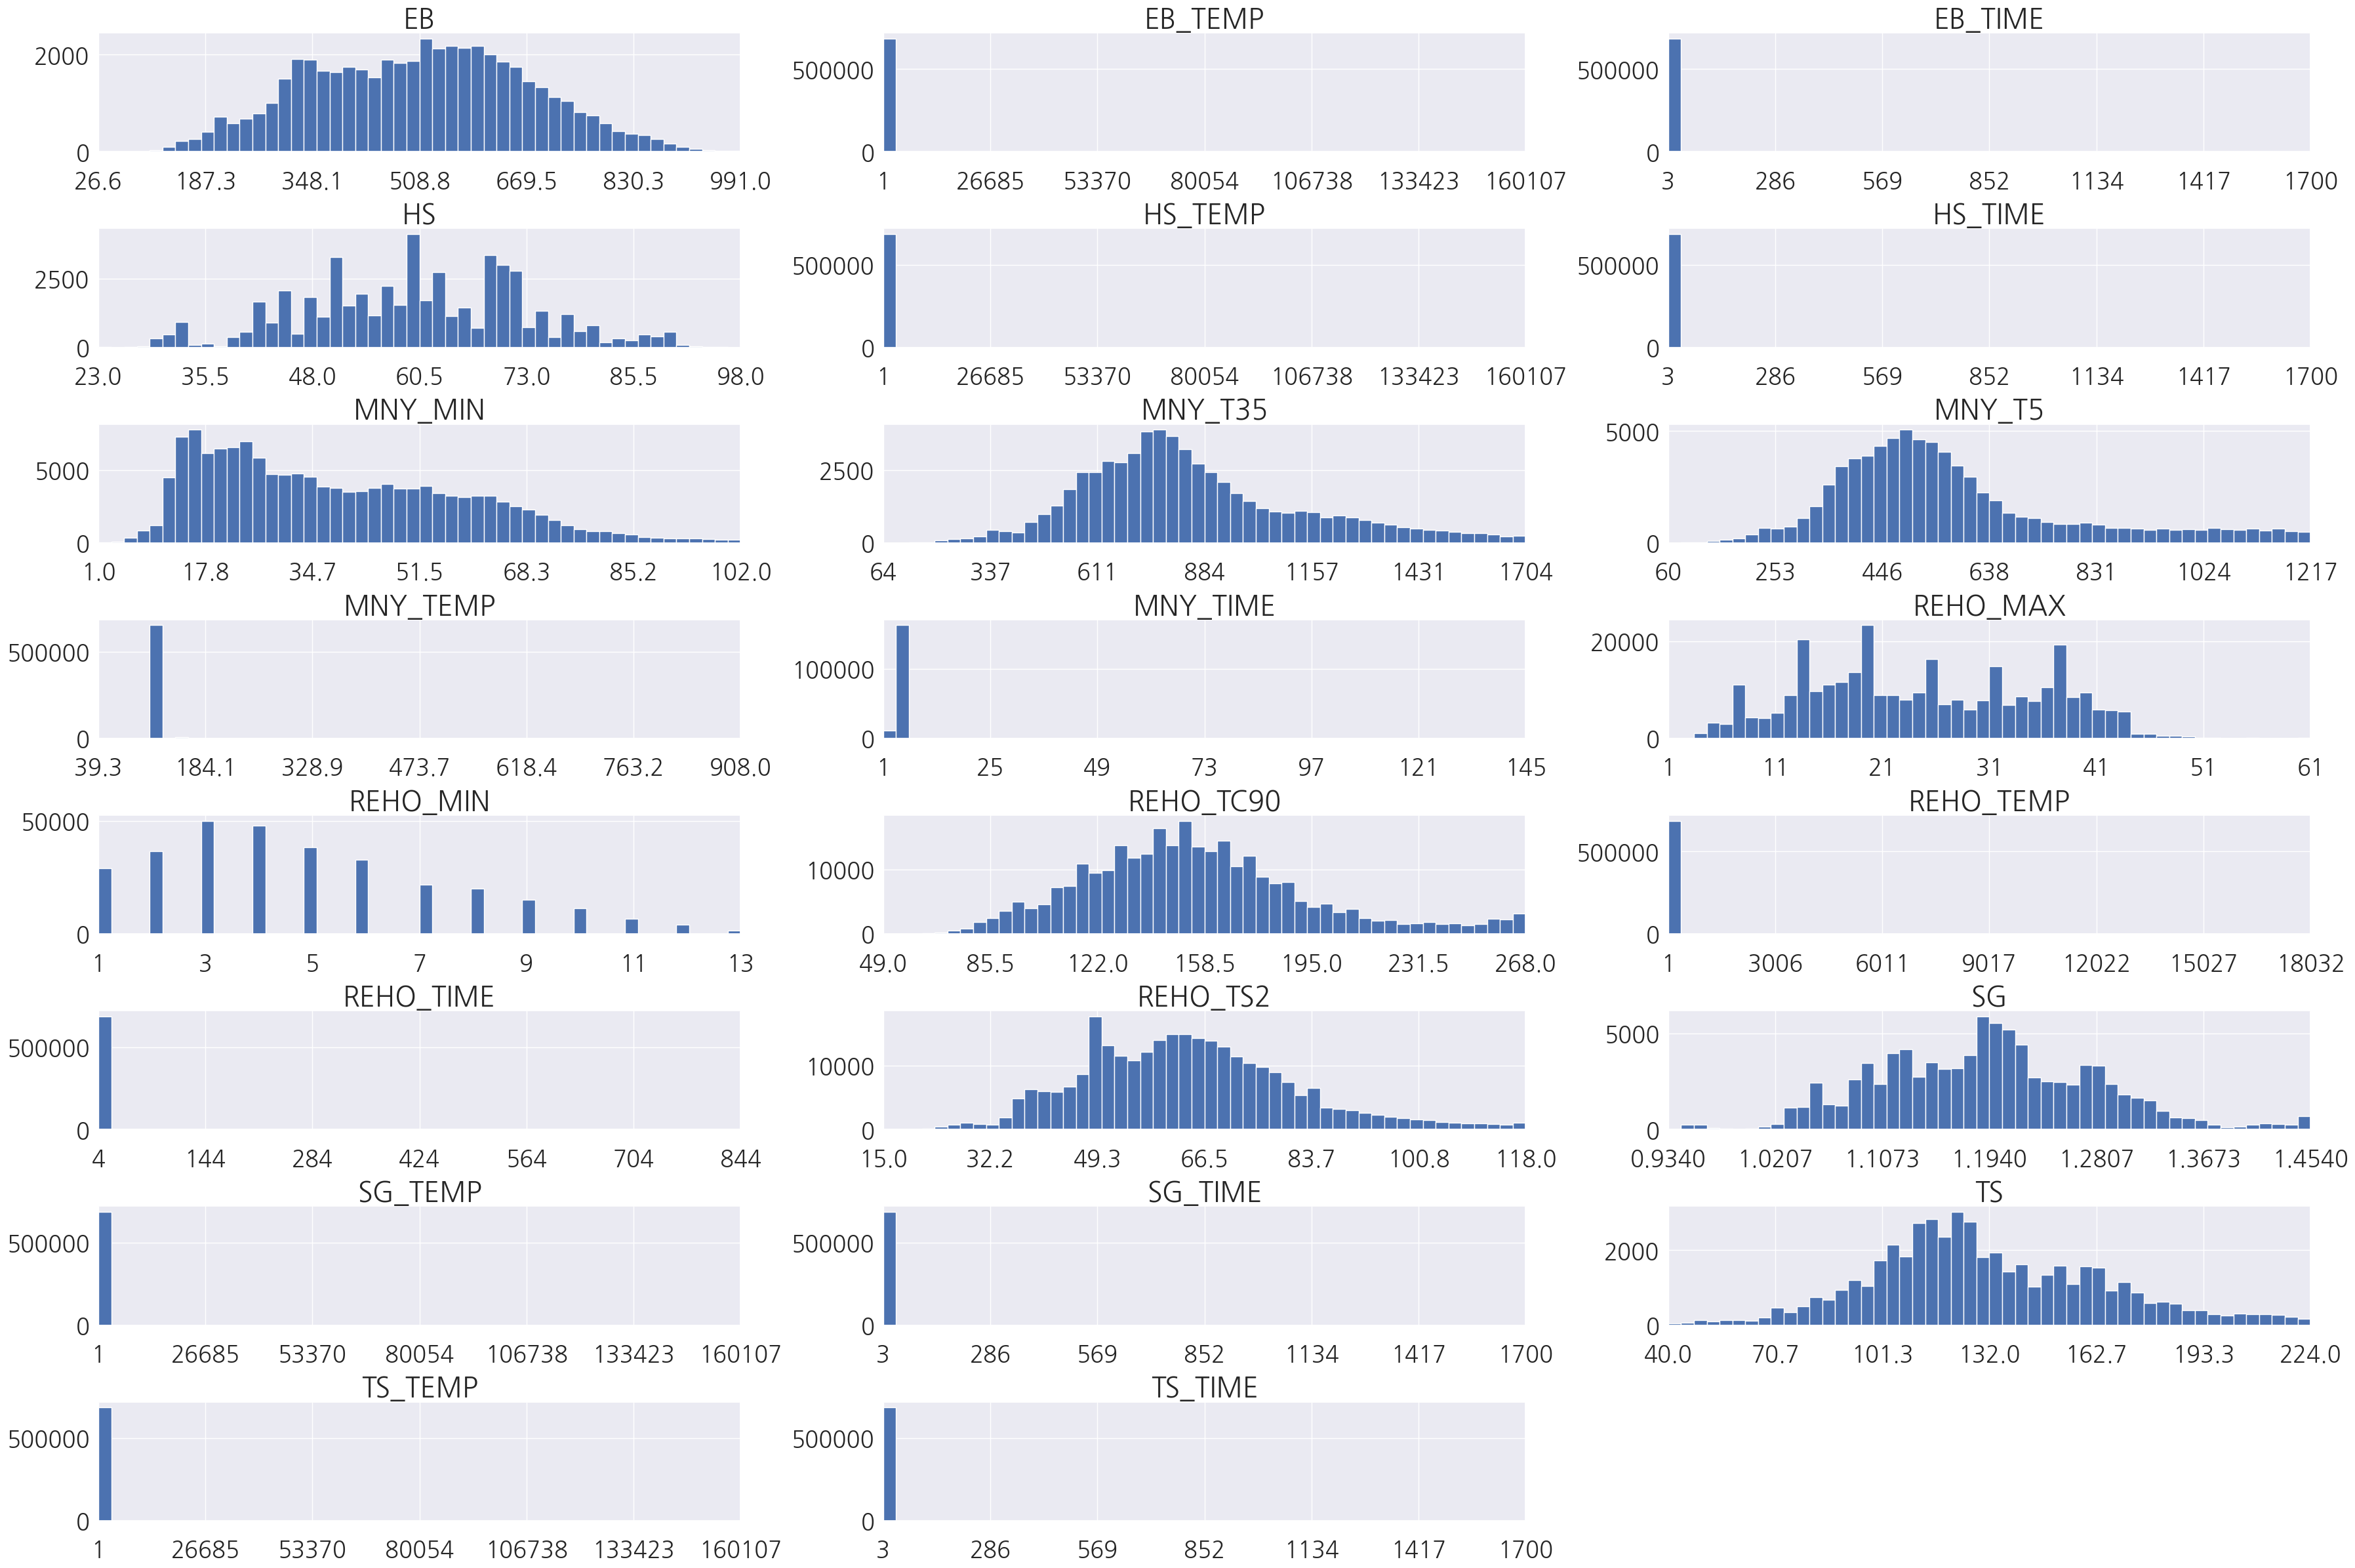

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['axes.labelsize'] = 50  # x, y축 레이블 폰트 크기
plt.rcParams['axes.titlesize'] = 30  # 타이틀 폰트 크기
plt.rcParams['xtick.labelsize'] = 25  # x축 틱 레이블 폰트 크기
plt.rcParams['ytick.labelsize'] = 25  # y축 틱 레이블 폰트 크기

numeric_columns = clean_df.select_dtypes(include=['number']).columns
tmp_clean_df = clean_df[numeric_columns]

# 히스토그램 생성
fig, axes = plt.subplots(len(tmp_clean_df.columns) // 3 + 1, 3, figsize=(36, 24))
axes = axes.flatten()

# 히스토그램과 x축 설정
for ax, col in zip(axes, tmp_clean_df.columns):
    tmp_clean_df[col].hist(bins=50, ax=ax)
    ax.set_title(col)  # 축 제목 설정
    data_min = tmp_clean_df[col].min()
    data_max = tmp_clean_df[col].max()  # 데이터의 최대값 계산
    x_min, x_max = ax.get_xlim()

    # X축의 범위를 데이터의 최소값과 최대값으로 설정
    ax.set_xlim(left=data_min, right=data_max)
    ax.set_xticks(np.linspace(data_min, data_max, num=7))
    
    # X축 레이블 위치를 더 아래로 조정
    ax.tick_params(axis='x', which='major', pad=15)  # x축 눈금 레이블의 패딩 조정

# 사용하지 않는 서브플롯 숨기기
for i in range(len(tmp_clean_df.columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [30]:
tmp_clean_df = clean_df.copy()
tmp_clean_df.dropna(how='all')

,EB,EB_TEMP,EB_TIME,HS,HS_TEMP,HS_TIME,ID,MNY_MIN,MNY_T35,MNY_T5,MNY_TEMP,MNY_TIME,REHO_MAX,REHO_MIN,REHO_TC90,REHO_TEMP,REHO_TIME,REHO_TS2,SG,SG_TEMP,SG_TIME,TS,TS_TEMP,TS_TIME,type
0,NaN,160.0,10.0,NaN,160.0,10.0,0000QA001_T001,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,lab
1,NaN,170.0,10.0,NaN,170.0,10.0,0000QY001_K001,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0,lab
2,NaN,170.0,10.0,NaN,170.0,10.0,0000QY001_k002,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0,lab
3,NaN,170.0,10.0,NaN,170.0,10.0,0000QY001_T001,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0,lab
4,NaN,170.0,10.0,NaN,170.0,10.0,0000QY001_T002,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0,lab
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848720,NaN,160.0,10.0,NaN,160.0,10.0,G0118I060010018,NaN,NaN,NaN,125.0,5.0,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,mes
848721,NaN,160.0,10.0,NaN,160.0,10.0,G0118I060032007,NaN,NaN,NaN,125.0,5.0,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,mes
848722,NaN,160.0,10.0,NaN,160.0,10.0,G0118I070045003,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,mes
848723,NaN,160.0,10.0,NaN,160.0,10.0,G0118G120045015,NaN,NaN,NaN,125.0,5.0,NaN,NaN,NaN,160.0,8.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,mes


In [32]:
clean_df.to_pickle('./dataset/clean_lab_mes_dataset.pkl')